# Example 03: Causal discovery with no known causal graph

-------------------------------------------

## Overview


 - AitiaExplorer allows you to do causal discovery even when you don't know have a preexisting causal graph for your data.
 - If no target causal graph is supplied, then AitiaExplorer will create an approximate graph using a greedy hill clmbing algorithm.
 - In this example below, we will simulate a scenario with no known causal graph, but we will also compare the approximated graph against the known causal graph.

### Imports

In [93]:
import os
import sys
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pycausal.pycausal import pycausal

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from aitia_explorer.app import App

# stop the warning clutter
import warnings
warnings.filterwarnings('ignore')

### Set up for causal discovery

- First create an AitiaExplorer instance and using it to load some simulated data into a panda dataframe.
- We will be using the [HEPAR II](https://www.bnlearn.com/bnrepository/#hepar2) dataset.
- This dataset has a known causal graph, but we will ignore that except to compare it to the approximated graph.

In [3]:
aitia = App()

In [124]:
df = aitia.data.hepar2_10k_data()

In [7]:
df.head()

,alcoholism,vh_amn,hepatotoxic,THepatitis,hospital,surgery,gallstones,choledocholithotomy,injections,transfusion,...,spiders,jaundice,albumin,edge,irregular_liver,hbc_anti,hcv_anti,palms,hbeag,carcinoma
0,-0.406818,-0.462320,-0.296683,-0.21094,-1.071769,-0.862721,2.360149,2.517292,-0.810725,-0.442913,...,-0.515114,1.616390,-0.956489,-0.600145,2.58011,-0.322863,-0.04363,2.248763,-0.060108,-0.260176
1,-0.406818,-0.462320,-0.296683,-0.21094,-1.071769,1.159123,2.360149,2.517292,-0.810725,-0.442913,...,1.941318,1.616390,0.531284,1.666264,-0.38758,-0.322863,-0.04363,-0.444689,-0.060108,-0.260176
2,-0.406818,-0.462320,-0.296683,-0.21094,-1.071769,1.159123,-0.423702,-0.397252,1.233463,-0.442913,...,1.941318,-0.618663,0.531284,-0.600145,-0.38758,-0.322863,-0.04363,-0.444689,-0.060108,-0.260176
3,-0.406818,-0.462320,-0.296683,-0.21094,-1.071769,-0.862721,-0.423702,-0.397252,-0.810725,-0.442913,...,1.941318,-0.618663,0.531284,-0.600145,-0.38758,-0.322863,-0.04363,-0.444689,-0.060108,-0.260176
4,-0.406818,2.163005,-0.296683,-0.21094,-1.071769,-0.862721,-0.423702,-0.397252,-0.810725,-0.442913,...,-0.515114,-0.618663,0.531284,-0.600145,-0.38758,-0.322863,-0.04363,-0.444689,-0.060108,-0.260176


- Now we need to select the causal discovery algorithms and feature selection algorithms to use.

In [113]:
feature_selection_list = []
feature_selection_list.append(aitia.feature_selection.LINEAR_REGRESSION)
feature_selection_list.append(aitia.feature_selection.RANDOM_FOREST)
feature_selection_list.append(aitia.feature_selection.RECURSIVE_FEATURE_ELIMINATION)

In [114]:
algorithm_list = []
algorithm_list.append(aitia.algo_runner.PC)
algorithm_list.append(aitia.algo_runner.FCI)
algorithm_list.append(aitia.algo_runner.RFCI_continuous)

### Run the causal discovery analysis

- Now we will run the causal discovery analysis.
- First we need to start a background Java VM using py-causal as the algorithms are implemented in Java.
- Then we will run the analysis using the `run_analysis` method and AitiaExplorer will return a summary and some useful results.
- We will set the number of features arbitrarily at 7.
- No target causal graph will be given, an approximate target graph will be supplied by the `run_analysis` method allow with the results.

In [13]:
pc = pycausal()
pc.start_vm()

In [125]:
results, summary, target_graph = aitia.run_analysis( 
                                       df,
                                       target_graph_str=None, # no target graph, force system to create one
                                       n_features=7,
                                       feature_selection_list=feature_selection_list,
                                       algorithm_list=algorithm_list,
                                       pc=pc)

No target graph has been supplied.
The system will generate an approximate target graph using the greedy hill climbing algorithm.
Running causal discovery on features selected by LINEAR_REGRESSION
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on features selected by LINEAR_REGRESSION
Running causal discovery on features selected by RANDOM_FOREST
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on features selected by RANDOM_FOREST
Running causal discovery on features selected by RECURSIVE_FEATURE_ELIMINATION
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on featu

### Display the results

- The results can then be examined using the summary which is just a returned dataframe.
- The AUPRC is a measure of the Area Under the Precision Recall curve, a useful performance metric.
- The Structural Hamming Distance (SHD) measures how close the graph returned by the causal algorithm was to the approximated target graph.

In [152]:
display(HTML(summary.to_html()))

,No. of Features Req.,Causal Algorithm,Feature Selection Method,AUPRC,SHD
0,7,PC,LINEAR_REGRESSION,0.510102,99.0
1,7,FCI,LINEAR_REGRESSION,0.510102,99.0
2,7,RFCI-continuous,LINEAR_REGRESSION,0.510102,99.0
3,7,PC,RANDOM_FOREST,0.265051,99.0
4,7,FCI,RANDOM_FOREST,0.265051,99.0
5,7,RFCI-continuous,RANDOM_FOREST,0.265051,99.0
6,7,PC,RECURSIVE_FEATURE_ELIMINATION,0.510102,99.0
7,7,FCI,RECURSIVE_FEATURE_ELIMINATION,0.510102,99.0
8,7,RFCI-continuous,RECURSIVE_FEATURE_ELIMINATION,0.510102,99.0


### Compare the approximated target graph to the actual target graph

- For the sake of this experiment, we ignored the actual target graph for the data, which is known.
- We can now compare the known target graph with the approximated graph created by AitiaExplorer.

In [127]:
actual_target_str_dot = aitia.data.hepar2_graph()
actual_target_graph = aitia.graph_util.get_causal_graph_from_dot(actual_target_str_dot)

- We need to convert the graphs to NetworkX graph so that they can be compared.

In [128]:
approx_target_graph = nx.DiGraph(target_graph.graph)
actual_target_graph = nx.DiGraph(actual_target_graph.graph)

- Now we can compare the SHD.

In [129]:
print('The SHD between approx and actual graph is ', 
      aitia.graph_metrics.SHD(
          approx_target_graph, 
          actual_target_graph))

The SHD between approx and actual graph is  84


- So we can see there is a difference between the approximate and actual graphs. This is to be expected.
- But does this have an effect on the causal discovery?

### Compare the causal discovery of approximated target graph to the actual target graph

- We will now run the causal discovery against the actual graph and compare the results to the earlier results using the approximated graph.

In [130]:
results2, summary2, _ = aitia.run_analysis( 
                                       df,
                                       target_graph_str=actual_target_str_dot, 
                                       n_features=7,
                                       feature_selection_list=feature_selection_list,
                                       algorithm_list=algorithm_list,
                                       pc=pc)

Running causal discovery on features selected by LINEAR_REGRESSION
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on features selected by LINEAR_REGRESSION
Running causal discovery on features selected by RANDOM_FOREST
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on features selected by RANDOM_FOREST
Running causal discovery on features selected by RECURSIVE_FEATURE_ELIMINATION
There are 0 latent edges in the reduced dataset
Running causal discovery using PC
Running causal discovery using FCI
Running causal discovery using RFCI-continuous
Completed causal discovery on features selected by RECURSIVE_FEATURE_ELIMINATION
Completed analysis.


In [131]:
display(HTML(summary2.to_html()))

,No. of Features Req.,Causal Algorithm,Feature Selection Method,AUPRC,SHD
0,7,PC,LINEAR_REGRESSION,0.512551,123.0
1,7,FCI,LINEAR_REGRESSION,0.512551,123.0
2,7,RFCI-continuous,LINEAR_REGRESSION,0.512551,123.0
3,7,PC,RANDOM_FOREST,0.012551,125.0
4,7,FCI,RANDOM_FOREST,0.012551,125.0
5,7,RFCI-continuous,RANDOM_FOREST,0.012551,125.0
6,7,PC,RECURSIVE_FEATURE_ELIMINATION,0.512551,123.0
7,7,FCI,RECURSIVE_FEATURE_ELIMINATION,0.512551,123.0
8,7,RFCI-continuous,RECURSIVE_FEATURE_ELIMINATION,0.512551,123.0


- If we actually compare the SHD and AUPRC for both causal discovery runs, we find that there is a difference in magnitude but the results are similar.
- The SHD is nearly flat in both cases and the AUPRC has a similar shape in both runs.
- As the approximate causal graph is only meant to be a benchmark heuristic, it seems a reasonable compromise to use it in situations where the causal graph is unknown, especially when it seems that the results returned from the actual causal graph are comparable.

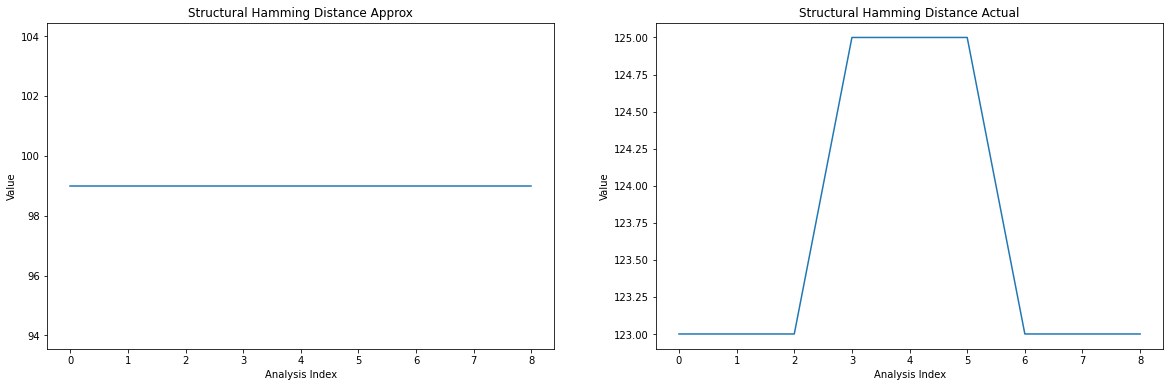

In [151]:
plt.rcParams["figure.figsize"] = (20, 6)

plt.subplot(1, 2, 1)
plt.plot(summary.index, summary['SHD'])
plt.title('Structural Hamming Distance Approx')
plt.xlabel('Analysis Index')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(summary2.index, summary2['SHD'])
plt.title('Structural Hamming Distance Actual')
plt.xlabel('Analysis Index')
plt.ylabel('Value')

plt.show()

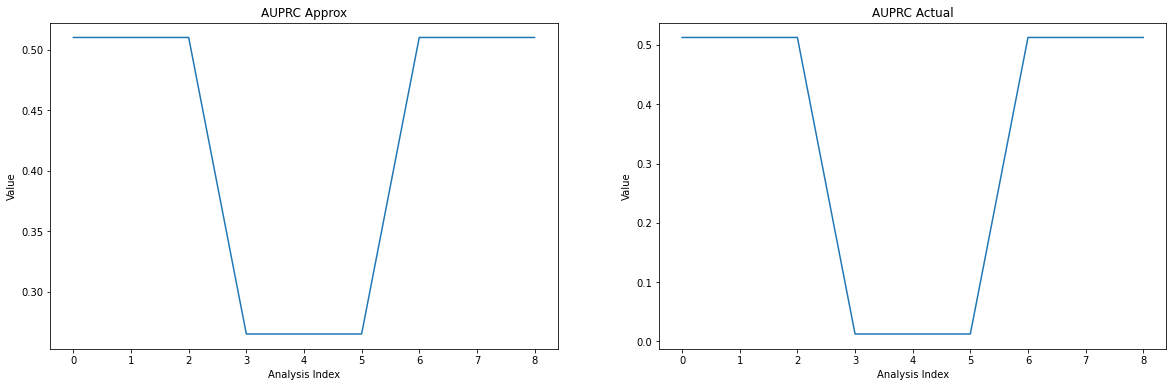

In [150]:
plt.rcParams["figure.figsize"] = (20, 6)

plt.subplot(1, 2, 1)
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(summary.index, summary['AUPRC'])
plt.title('AUPRC Approx')
plt.xlabel('Analysis Index')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(summary2.index, summary2['AUPRC'])
plt.title('AUPRC Actual')
plt.xlabel('Analysis Index')
plt.ylabel('Value')

plt.show()